# Investigating the house price on cottage

Imports and set magics:

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
import requests
import pandas as pd
import re
from collections import defaultdict
from pathlib import Path
import csv
from lxml import html
import requests


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
from dataproject import NyboligScraper
from dataproject import NyboligAnalysis
from test import NyBoligParser
from test import HouseListingsScraper



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Inside the website html we identify the specific element that contains information on property listings. The element has three "children" that contains relevant information; address, price and mix. We scrape these "children" together and get the following dataset:

In [108]:
def scrape_page(property_type,page_num):
    # Create a scraper for the given page
    scraper = HouseListingsScraper("https://www.nybolig.dk/til-salg", property_type=property_type, page_num=page_num)
    # Scrape listings data from the page
    return scraper.parse_listings()

def main():

    lst = []

    for i in range(1,50):
        parser = NyBoligParser(scrape_page("sommerhus",i))
        parser.parse_listings()
        lst.append(parser.data_to_df())

    df = pd.concat(lst)

    df.to_csv('output.csv', index=False)
main()
df = pd.read_csv('raw_output.csv')
df.head()


https://www.nybolig.dk/til-salg/sommerhus?page=1
https://www.nybolig.dk/til-salg/sommerhus?page=2
https://www.nybolig.dk/til-salg/sommerhus?page=3
https://www.nybolig.dk/til-salg/sommerhus?page=4
https://www.nybolig.dk/til-salg/sommerhus?page=5
https://www.nybolig.dk/til-salg/sommerhus?page=6
https://www.nybolig.dk/til-salg/sommerhus?page=7
https://www.nybolig.dk/til-salg/sommerhus?page=8
https://www.nybolig.dk/til-salg/sommerhus?page=9
https://www.nybolig.dk/til-salg/sommerhus?page=10
https://www.nybolig.dk/til-salg/sommerhus?page=11
https://www.nybolig.dk/til-salg/sommerhus?page=12
https://www.nybolig.dk/til-salg/sommerhus?page=13
https://www.nybolig.dk/til-salg/sommerhus?page=14
https://www.nybolig.dk/til-salg/sommerhus?page=15
https://www.nybolig.dk/til-salg/sommerhus?page=16
https://www.nybolig.dk/til-salg/sommerhus?page=17
https://www.nybolig.dk/til-salg/sommerhus?page=18
https://www.nybolig.dk/til-salg/sommerhus?page=19
https://www.nybolig.dk/til-salg/sommerhus?page=20
https://w

,"Ballesvej 5, Sillerslev, 7990 Øster Assels",1.995.000,Fritidsbolig | 4 vær. | 97 m
0,"Drejet 36D, Spodsbj Drej, 5900 Rudkøbing",1.845.000,Fritidsbolig | 4 vær. | 83 m
1,"Engdraget 5, Hou, 9370 Hals",1.040.000,Fritidsbolig | 3 vær. | 93/76 m
2,"Hjelmvej 13, Elsegårde Strand",1.298.000,Fritidsbolig | 3 vær. | 40 m
3,"Baroniet 22, 3100 Hornbæk",4.195.000,Fritidsbolig | 4 vær. | 99 m
4,"Slunden 56, Rindby Strand, 6720 Fanø",2.495.000,Fritidsbolig | 5 vær. | 92 m


This dataframe does not hold much analytical value as specific variables of interest is bundeled together within the columns. To circumvent this issue we parse the data so we can perform analysis on the property listings. 

In [109]:
df = pd.read_csv('output.csv')
df.head()

,full_address,postal_code,city,price,type,rooms,sq_m,sq_m_cellar
0,"Ballesvej 5, Sillerslev, 7990 Øster Assels",7990.0,Øster Assels,1995000,Fritidsbolig,4,97,NaN
1,"Drejet 36D, Spodsbj Drej, 5900 Rudkøbing",5900.0,Rudkøbing,1845000,Fritidsbolig,4,83,NaN
2,"Engdraget 5, Hou, 9370 Hals",9370.0,Hals,1040000,Fritidsbolig,3,93,76.0
3,"Hjelmvej 13, Elsegårde Strand",NaN,Elsegårde Strand,1298000,Fritidsbolig,3,40,NaN
4,"Baroniet 22, 3100 Hornbæk",3100.0,Hornbæk,4195000,Fritidsbolig,4,99,NaN


We start by parsing address

This code scrapes data for summer houses for sale from the nybolig.dk website, cleans and preprocesses the data, and performs some basic exploratory data analysis. Specifically, the code collects the address, postcode, city, price, type, number of rooms, and size of each listing, and stores the data in a CSV file. Then it uses pandas to read the data from the CSV file, performs some basic data cleaning (removing outliers and parsing data), and computes some summary statistics and OLS regression models. Finally, the code produces various plots, including bar plots for average house prices by city and average square meter price by city, and scatter plots for price vs size for the lowest and highest price cities. 

Note that the results may differ depending on the specification of the scraping process. Ultimately, the user is in control of the dataset as they can choose the size and what types of listings that they scrape. The time of scraping may also alter the results, as listings are frequently removed and/or added to the website. 

# Scraping data

First we need to scrape the data from the internet. The data is scraped from https://www.nybolig.dk/. To know how many pages is possible to scrape you can call the get_pages function of the following property types:

**All**: ''
**Andelsbolig**: 'andelsbolig'
**Ejerlejlighed**: 'ejerlejlighed'
**Sommerhusgrunde**: 'fritidsgrund'
**Grunde**: 'helaarsgrund'
**Hus**: 'hus'
**Landejendomme**: 'landejendom'
**Rækkehuse**:  'raekkehus'
**Sommerhuse**: 'sommerhus'
**Villalejligheder**:   'villalejlighed'


The number of pages that you choose will determine the size of the dataset.

Next, we need to identify what property types and how many pages we want to work with. To do this you can call the scraper.scrape_data_nybolig(self, num_pages, property_type=None, file_name=None) function. This will save the desired data into a CSV file that we will be able to work with. Note that it might take some time to scrape the data. 200 pages will take around 1 and half minute. 

# Accessing Data

Now that we have created the dataset we need to access it. To do this please provide the path of this dictionary with the filename.

# Analysis

In [110]:
file_path = 'output.csv'
analysis = NyboligAnalysis(file_path)

To make the analysis more accurate we need to remove outliers from the dataset. We can do this by using the remove_outliers functions from the NyboligAnalysis class. The remove_outliers() function takes three arguments: column_name, minimum number of city observations and a threshold. column_name specifies the name of the column that we want to remove outliers from, the second input removes cities that have below x number of observations and threshold specifies the number of standard deviations above or below the mean that we want to consider as outliers.

In [111]:
analysis.remove_outliers('rooms', 5, 15)
analysis.remove_outliers('sq_m', 5, 7)

**Descriptive statistics**

Change the list (lst) to perform descriptive statistics on variables of your choosing

In [112]:
lst = ['price', 'rooms', 'sq_m']

for i in lst:
    info = analysis.descriptive_statistics(i)
    print(info)
    print()


       count          mean           std    min        25%        50%  \
price    735  2.459984e+06  2.424485e+06  10000  1295000.0  1849000.0   

             75%       max  
price  2798000.0  37000000  

       count      mean       std  min  25%  50%  75%  max
rooms    735  3.948299  1.325723    0  3.0  4.0  5.0   13

      count       mean        std  min   25%   50%    75%  max
sq_m    735  94.197279  41.882774   20  66.0  87.0  114.0  316



The dataset consists of 4.099 property samples, providing information on price, number of rooms, and size (in square meters). For the property prices, the average value is approximately 2.329.591 with a standard deviation of 2,099,168. The minimum price is 520.000, and the maximum price is 32,500,000. The 25th percentile is 1,250,000, the median (50th percentile) is 1.795.000, and the 75th percentile is 2.696.500.

In terms of the number of rooms, the average is about 3,92 with a standard deviation of 1,26. The minimum number of rooms is 0, and the maximum is 14. The 25th percentile is 3, the median is 4, and the 75th percentile is also 4.

Regarding the size of the houses (size_1), the average value is 91,01 square meters with a standard deviation of 40,76. The smallest property has 9 square meters, and the largest property has 401 square meters. The 25th percentile is 64 square meters, the median is 82 square meters, and the 75th percentile is 108 square meters.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     286.8
Date:                Mon, 22 May 2023   Prob (F-statistic):           1.51e-54
Time:                        17:00:40   Log-Likelihood:                -11726.
No. Observations:                 735   AIC:                         2.346e+04
Df Residuals:                     733   BIC:                         2.347e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.318e+05   1.87e+05     -2.311      0.0

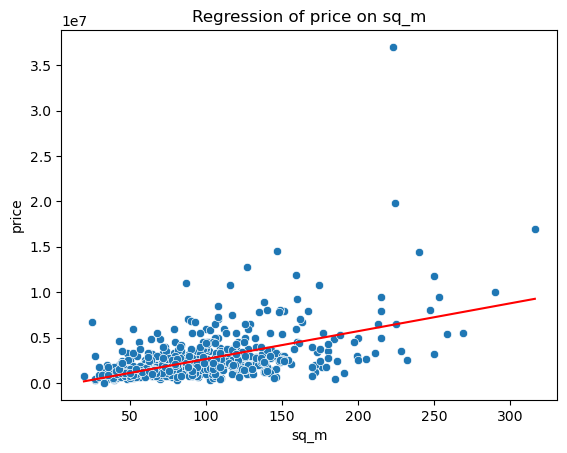

In [113]:
# Define the independent and dependent variables
X = analysis.data[['sq_m']]
y = analysis.data['price']

# Fit the OLS model and print the summary
summary = analysis.OLS(X, y)
print(summary)

# Plot the data with the regression line
analysis.plot_regression(X, y)

This OLS regression is performed on the house prices with size (size_1) as the independent variable. The model has an R-squared value of 0,221 and an adjusted R-squared value of 0.221, indicating that approximately 22,1% of the variation in house prices can be explained by the property size. 

The coefficient is 24.220 with a standard error of 710,15, and it is statistically significant (p-value < 0,001). This indicates that for each additional square meter, the house price increases by 24.220 kr. on average.


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     125.7
Date:                Mon, 22 May 2023   Prob (F-statistic):           4.84e-27
Time:                        17:00:42   Log-Likelihood:                -11790.
No. Observations:                 735   AIC:                         2.358e+04
Df Residuals:                     733   BIC:                         2.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.029e+05    2.6e+05     -1.166      0.2

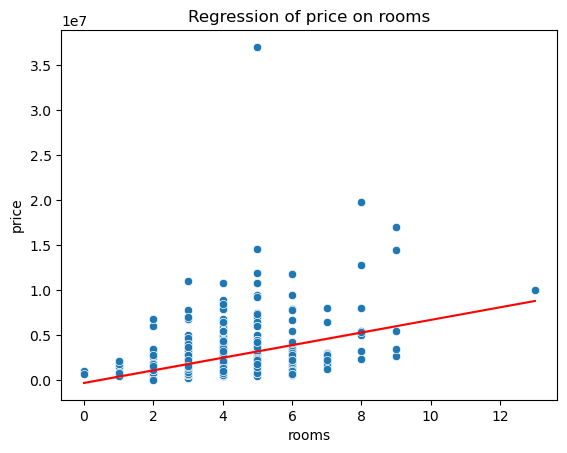

In [114]:
# Define the independent and dependent variables
X = analysis.data[['rooms']]
y = analysis.data['price']

# Fit the OLS model and print the summary
summary = analysis.OLS(X, y)
print(summary)

# Plot the data with the regression line
analysis.plot_regression(X, y)

This OLS regression is performed on the house prices with the number of rooms (rooms) as the independent variable. The model has an R-squared value of 0,132 and an adjusted R-squared value of 0,132, indicating that approximately 13,2% of the variation in house prices can be explained by the number of rooms.

The coefficient is 604.200 with a standard error of 24.200, and it is statistically significant (p-value < 0.001). This indicates that for each additional room, the house price increases by 604.200 kr. on average.


# How does location affect the price?

To see how the location impact the house price we will calculate the average house price of each city. With the intention of visualizing the locations with the cities with the highest prices to the lowest we are creating a bar chart.

In [115]:
# Group the data by city and calculate the mean price
mean_prices_by_city = df.groupby('city')['price'].mean().reset_index()
mean_prices_by_city = mean_prices_by_city.sort_values('price', ascending=False).head(50)


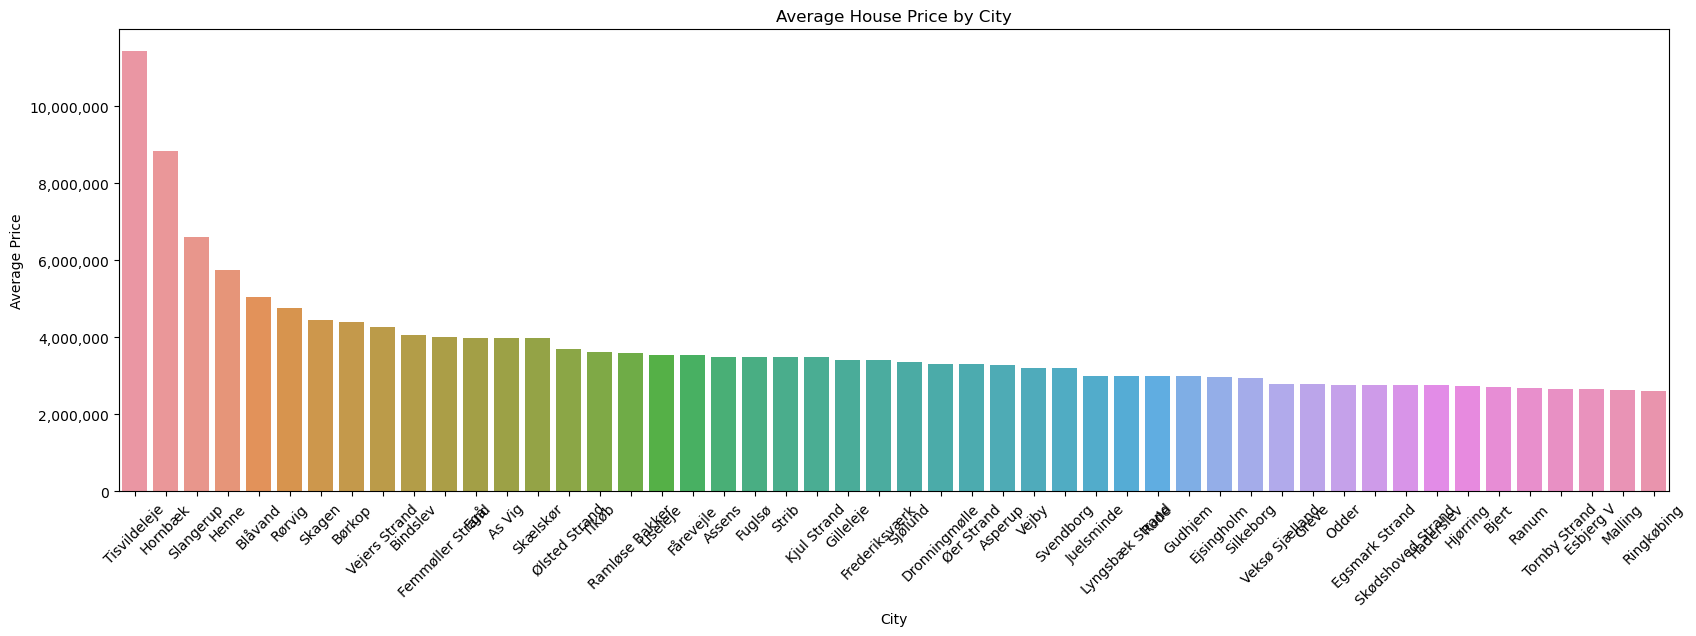

In [116]:
from matplotlib.ticker import FuncFormatter

def price_formatter(x, _):
    return f'{int(x):,}'

formatter = FuncFormatter(price_formatter)

plt.figure(figsize=(20, 6))
ax = sns.barplot(x='city', y='price', data=mean_prices_by_city)
plt.title('Average House Price by City')
plt.xticks(rotation=45)
plt.ylabel('Average Price')
plt.xlabel('City')

ax.yaxis.set_major_formatter(formatter)
plt.show()


We can see from this that the location seems to have a big impact on the houses as the average house price in Tisvilde and Hornbæk is almost twice as high as the cities with the lowest prices.

# Comparing the highest and lowest price city

In [123]:
# After updating the `min_max_postcode` method in your NyboligAnalysis class...
analysis = NyboligAnalysis(file_path)
min_max_postcodes = analysis.min_max_postcode()
(min_price, min_postal_code, min_city), (max_price, max_postal_code, max_city) = min_max_postcodes
print(f"The lowest average price is {min_price:.2f} and corresponds to postal code {min_postal_code} in {min_city}")
print(f"The highest average price is {max_price:.2f} and corresponds to postal code {max_postal_code} in {max_city}")


KeyError: 'postcode'

In [122]:
print(df.columns)


Index(['full_address', 'postal_code', 'city', 'price', 'type', 'rooms', 'sq_m',
       'sq_m_cellar', 'square_meter_price'],
      dtype='object')


In [118]:
# Use the revised min_max_postcode method
min_max_postcodes = analysis.min_max_postcode()
(min_price, min_postal_code, min_city), (max_price, max_postal_code, max_city) = min_max_postcodes
print(f"The lowest average price is {min_price:.2f} and corresponds to postal code {min_postal_code} in {min_city}")
print(f"The highest average price is {max_price:.2f} and corresponds to postal code {max_postal_code} in {max_city}")

# Get the lowest and highest price cities
lowest_price_city = min_city
highest_price_city = max_city

# Filter the data to only include the lowest and highest price cities
lowest_price_data = df[df['city'] == lowest_price_city]
highest_price_data = df[df['city'] == highest_price_city]

# Average number of rooms comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=[min_city, max_city], y=[df[df['city']==min_city]['rooms'].mean(), df[df['city']==max_city]['rooms'].mean()])
plt.title(f'Average Number of Rooms in {min_city} and {max_city}')
plt.ylabel('Average Number of Rooms')
plt.xlabel('City')
plt.show()

# Size comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=[min_city, max_city], y=[df[df['city']==min_city]['size'].mean(), df[df['city']==max_city]['size'].mean()])
plt.title(f'Average Size in {min_city} and {max_city}')
plt.ylabel('Average Size')
plt.xlabel('City')
plt.show()

# Price comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=[min_city, max_city], y=[df[df['city']==min_city]['price'].mean(), df[df['city']==max_city]['price'].mean()])
plt.title(f'Average Price in {min_city} and {max_city}')
plt.ylabel('Average Price')
plt.xlabel('City')
plt.show()

# Create a scatter plot for the lowest and highest price cities
plt.figure(figsize=(8, 6))
plt.scatter(lowest_price_data['size'], lowest_price_data['price'], label=lowest_price_city)
plt.scatter(highest_price_data['size'], highest_price_data['price'], label=highest_price_city)
plt.title(f"Price vs Size for {lowest_price_city} and {highest_price_city}")
plt.xlabel('Size')
plt.ylabel('Price')
plt.legend()
plt.show()


KeyError: 'postcode'

These graphs shows that the average rooms and size in the houses in Tisvildeleje is higher than in Tarm supporting our OLS regression. 

In our OLS regression we saw that the size of the house is determined to have a positive impact on the price of the house. From our graph on average house prices we found the lowest and highest priced cities. To look further into this, we want to see if the average house size and rooms in the high price city is higher than the houses in low price city to support our results of the OLS regression. 

From this we see that the size of the house does not have a significant big impact on the price of the house in the low price city. On the other hand, the size of the house is considered to have a very significant impact on the price in Hornbæk. There can be several reasons for this. It may be a result of the interest in houses in the low price city is very low why the price may be generally low for all the houses no matter the size - this is not something we are going to investigate in this assignment, but it is something that would be interesting to look into in another context.

# Do the results change if we control for size?

In [120]:
# Calculate the square meter price
df['square_meter_price'] = df['price'] / df['sq_m']

# Calculate the mean square meter price by city
mean_average_prices_by_city = df.groupby('city')['square_meter_price'].mean().reset_index()
mean_average_prices_by_city = mean_average_prices_by_city.sort_values('square_meter_price', ascending=False).head(50)
mean_average_prices_by_city['square_meter_price'] = mean_average_prices_by_city['square_meter_price'].astype(int)

# Plot the bar chart
plt.figure(figsize=(20, 6))
ax = sns.barplot(x='city', y='square_meter_price', df=mean_average_prices_by_city, order=mean_average_prices_by_city['city'])
plt.title('Average Square Meter Price by City')
plt.xticks(rotation=45)
plt.ylabel('Average Square Meter Price')
plt.xlabel('City')
ax.yaxis.set_major_formatter(formatter)
plt.show()



ValueError: Could not interpret input 'city'

<Figure size 2000x600 with 0 Axes>

In [ ]:
# Lowest Price cities
lowest_price_cities = data.groupby('city')['price'].mean().nsmallest(5).reset_index()['city'].tolist()
lowest_avg_price_cities = data.groupby('city')['square_meter_price'].mean().nsmallest(5).reset_index()['city'].tolist()
lowest_price_df = pd.DataFrame(lowest_price_cities, columns=['Lowest 5 Price Cities'])
lowest_avg_price_df = pd.DataFrame(lowest_avg_price_cities, columns=['Lowest 5 Average Square Meter Price Cities'])

# Highest Price cities
highest_price_cities = data.groupby('city')['price'].mean().nlargest(5).reset_index()['city'].tolist()
highest_avg_price_cities = data.groupby('city')['square_meter_price'].mean().nlargest(5).reset_index()['city'].tolist()
highest_price_df = pd.DataFrame(highest_price_cities, columns=['Highest 5 Price Cities'])
highest_avg_price_df = pd.DataFrame(highest_avg_price_cities, columns=['Highest 5 Average Square Meter Price Cities'])

# Concatenate the two dataframes
result_df = pd.concat([lowest_price_df, lowest_avg_price_df, highest_price_df, highest_avg_price_df], axis=1)
result_df


,Lowest 5 Price Cities,Lowest 5 Average Square Meter Price Cities,Highest 5 Price Cities,Highest 5 Average Square Meter Price Cities
0,Grindsted,Dybe,Tisvildeleje,Østermarie
1,Heldum,Ejsingholm,Asserbo,Karlslunde
2,Hobro,Langebæk,Hornbæk,Helsingør
3,Stokkemarke,Horslunde,Liseleje,Hørsholm
4,Aars,Stokkemarke,Hørsholm,Tisvildeleje


We see that the results change when we control for size. Tisvildeleje is relatively expensive in both aboslute price and square meter price.